<a href="https://colab.research.google.com/github/SCS-Technology-and-Innovation/DACS/blob/main/DTDA/flow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Go with the flow
## Network flows as models of propagation

Think of the sewers: a complex set of pipes of varying capacities, connected to one another. Many sources of water enter the sewer that leads to one or more specific targets (tanks or other types of reservoirs).

Alternatively, think of electric wiring inside the walls of a building. Or the powerlines that form the Québec power grid.

Or maybe cars driving along streets, arriving at intersections and taking a turn or continuing straight.

All these settings contain interconnected elements, each connection having a specific capacity, and a substance of sorts (waste water, electricity, or traffic) that propagates along that specific infrastructure.

To get started with studying how all this works, let's create a *connected* graph with *directed* edges (that is, connections that only allow flow in one direction, enforced by a **valve** or another mechanism for that purpose).

In [170]:
n = 10
m = n + 10

import networkx as nx

attempts = 50
while attempts > 0:
  U = nx.gnm_random_graph(n, m)
  if nx.is_connected(U):
    print('Connected!')
    break
  attempts -= 1

print(U)

G = U.to_directed(U) # orient the edges

if attempts == 0:
  print('Try again with more edges')
else:
  print('Good to go', G)

Connected!
Graph with 10 nodes and 20 edges
Good to go DiGraph with 10 nodes and 40 edges


It would be nice to visualize this. We already know how to draw edges. We can use arrowheads to indicate the direction and the line width to illustrate the capacity of each edge.

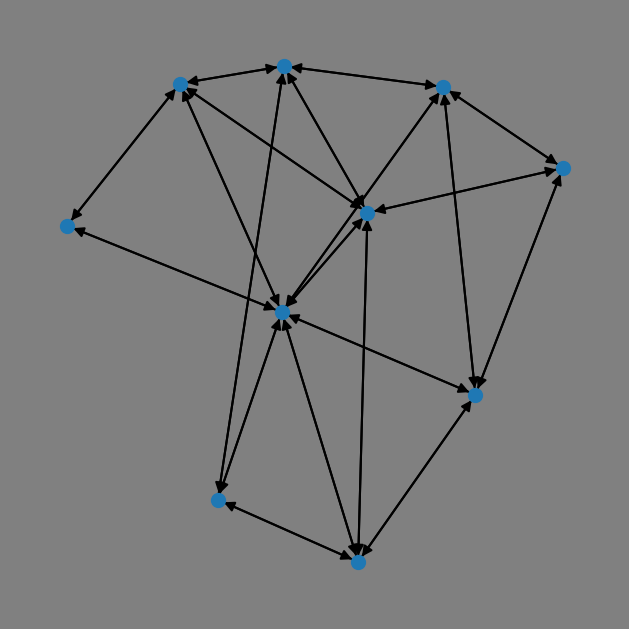

DiGraph with 10 nodes and 40 edges


In [171]:
L = nx.spring_layout(G)

import matplotlib.pyplot as plt
fig = plt.figure(1, figsize = (4, 4), dpi =  150)
nx.draw(G, pos = L, width = 1, node_size = 40)
fig.set_facecolor('gray')
plt.show()
print(G)

It is easy to see that when we oriented the edges, they became bidirectional by default. This was not our original intention, so we should now decide for each edge which of the two directions we wish to conserve.

In [172]:
from random import random

keep = set()
for u, v in G.edges():
    if random() < 0.5 and (v, u) not in keep:
      keep.add((u, v))
    elif (u, v) not in keep:
      keep.add((v, u))

for u in G.nodes():
    for v in G.nodes():
      if G.has_edge(u, v):
        if not (u, v) in keep:
          G.remove_edge(u, v)

print(G)

DiGraph with 10 nodes and 20 edges


Let's draw it again to see if we achieved our goal.

Now we have vertices and edges. What we wanted was to associate a **capacity** to each edge. We can do this uniformly at random for now (in the real world, one may wish to stop to think how the capacities might in fact be *distributed*).

In [173]:
from random import randint
low = 1
high = 5
for u, v in G.edges():
  G[u][v]['capacity'] = randint(low, high)

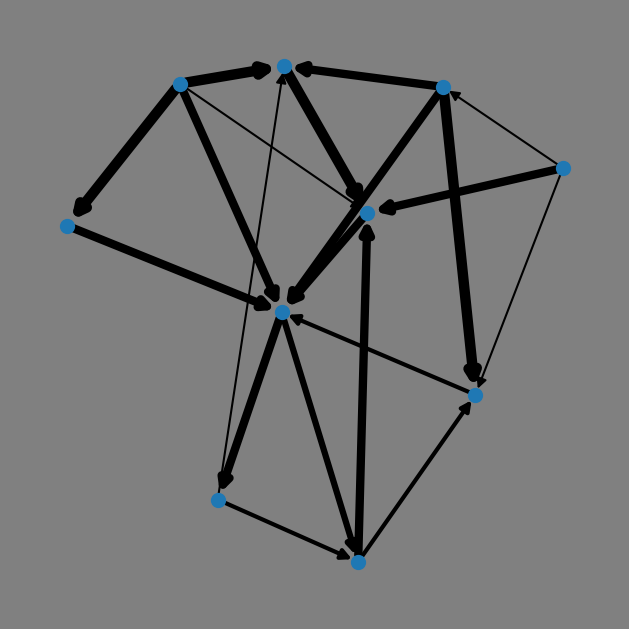

In [174]:
w = [ G[u][v]['capacity'] for u, v in G.edges ]

fig = plt.figure(1, figsize = (4, 4), dpi =  150)
nx.draw(G, pos = L, width = w, node_size = 40)
fig.set_facecolor('gray')
plt.show()

Okay. We are ready to start thinking about *flow* within this networked system.

The amount of substance that can flow through the system depends on where the substance *enters* the system (called the **source** of the flow) as well as on where the flow *exits* the system (the **sink** or the target of the flow).

We can try all source-sink **pairs** to see how much the total possible flow depends on these choices.

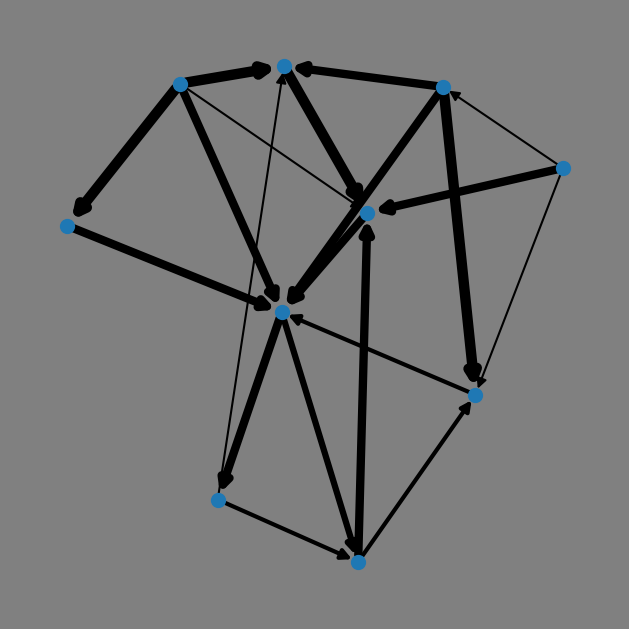

In [175]:
w = [ G[u][v]['capacity'] for u, v in G.edges ]

fig = plt.figure(1, figsize = (4, 4), dpi =  150)
nx.draw(G, pos = L, width = w, node_size = 40)
fig.set_facecolor('gray')
plt.show()

In [176]:
highest = 0
pair = None
config = None

for s in G.nodes(): # all possible sources
  for t in G.nodes(): # all possible sinks
    if s != t: # makes little sense for the same node to be both source and sink
      maxflow = nx.maximum_flow(G, s, t)
      value = maxflow[0] # maximum flow in units
      flow = maxflow[1] # a dictionary of the flow on each edge (as an adjacency list)
      active = sum( [ sum( [ f > 0 for f in flow[v].values() ] ) for v in flow ] )
      if value > 1 and active > 1: # see the interesting ones (more than one unit flows along two or more edges)
        if value > highest:
            print(f'A new record: total flow of {value} units from {s} to {t} along {active} edges')
            highest = value
            pair = (s, t)
            config = flow

A new record: total flow of 4 units from 0 to 3 along 4 edges
A new record: total flow of 5 units from 1 to 3 along 3 edges
A new record: total flow of 12 units from 2 to 1 along 6 edges


Let's take a look at how that highest flow that we stored is represented.

In [177]:
print(config)
print(pair)

{0: {1: 4}, 1: {7: 0, 3: 0}, 2: {8: 0, 9: 4, 1: 4, 0: 4}, 3: {4: 0, 8: 0}, 4: {1: 0}, 5: {9: 0, 1: 0, 4: 0}, 6: {4: 0, 8: 0, 5: 0}, 7: {3: 0, 9: 0}, 8: {1: 4}, 9: {8: 4}}
(2, 1)


For each vertex, it shows us the flow along each outgoing edge. Zero means the same as "nothing flows along this edge".

We could prepare edge labels for our visualization based on this, displaying both the flow along the edge and its capacity.

In [178]:
status = dict()
for v in config:
  for (u, units) in config[v].items():
    if units > 0:
      G[v][u]['flow'] = units
      cap = G[v][u]['capacity']
      status[(u, v)] = f'{units}/{cap}'

status

{(1, 0): '4/4',
 (9, 2): '4/5',
 (1, 2): '4/4',
 (0, 2): '4/5',
 (1, 8): '4/4',
 (8, 9): '4/5'}

We can draw again, using these labels on the edges and also coloring the edges in terms of how much flow they have.

2 1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


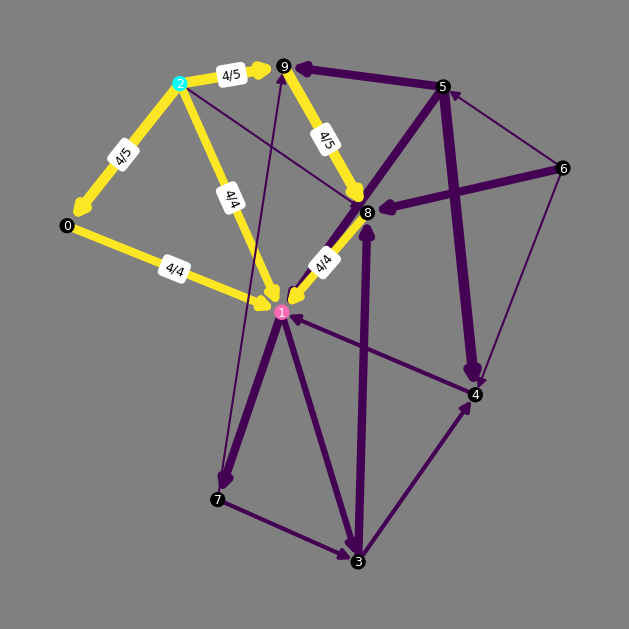

In [179]:
f = [ G[u][v]['capacity'] for u, v in G.edges ]
c = [ G[u][v].get('flow', 0) for u, v in G.edges ]

(s, t) = pair
print(s, t, G.nodes)
Vc = [ 'cyan' if v == s else ('hotpink' if v == t else 'black') for v in G.nodes ]

fig = plt.figure(1, figsize = (4, 4), dpi =  150)
nx.draw(G, pos = L, width = f, node_size = 40, node_color = Vc, edge_color = c, cmap = plt.cm.Greens)
nx.draw_networkx_edge_labels(G, L, status, font_size = 6)
nx.draw_networkx_labels(G, L, font_size = 6, font_color='white')
fig.set_facecolor('gray')
plt.show()

This would be easier to understand if we did not draw at all the vertices that play no part in the flow: nothing ever comes in and nothing ever goes out.

In [180]:
nothingGoesOut = set()
somethingComesIn = set()

for v in config:
  if sum(config[v].values()) == 0:
    nothingGoesOut.add(v)
  for u in config[v]:
    if config[v][u] > 0:
      somethingComesIn.add(u)

print(nothingGoesOut)
assert s not in nothingGoesOut # flow MUST come out of the source

print(somethingComesIn)

both = nothingGoesOut & somethingComesIn
assert t in both # the sink is allowed to "swallow" its incoming flow
assert len(both) == 1 # elsewhere, if something comes it, it must go out

pointless = nothingGoesOut - somethingComesIn
print(pointless) # these vertices are the redundant ones when we want to study the flow

{1, 3, 4, 5, 6, 7}
{0, 1, 9, 8}
{3, 4, 5, 6, 7}


We can make a copy of the graph without those vertices that do not partake in the flow we intend to visualize.

In [181]:
I = G.copy()
for v in pointless:
  I.remove_node(v)

We can draw again.

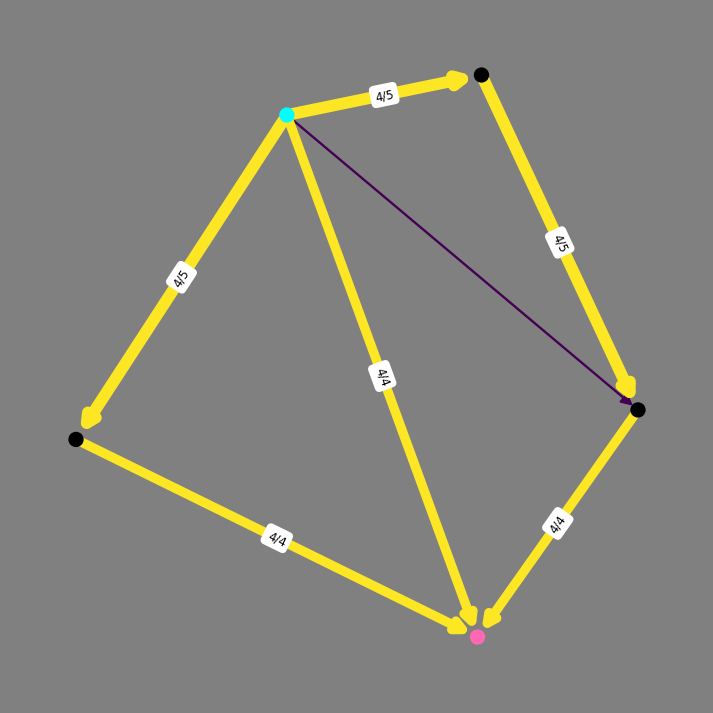

In [182]:
f = [ I[u][v]['capacity'] for u, v in I.edges ]
c = [ I[u][v].get('flow', 0) for u, v in I.edges ]

Vc = [ 'black' if v not in pair else ('cyan' if v == s else 'hotpink') for v in I.nodes ]

fig = plt.figure(1, figsize = (4, 4), dpi =  170)
nx.draw(I, pos = L, width = f, node_size = 30, node_color = Vc, edge_color = c, cmap = plt.cm.Greens)
nx.draw_networkx_edge_labels(I, L, status, font_size = 5)
fig.set_facecolor('gray')
plt.show()

We could also use an updated or an entirely different a layout to make more sense of this.

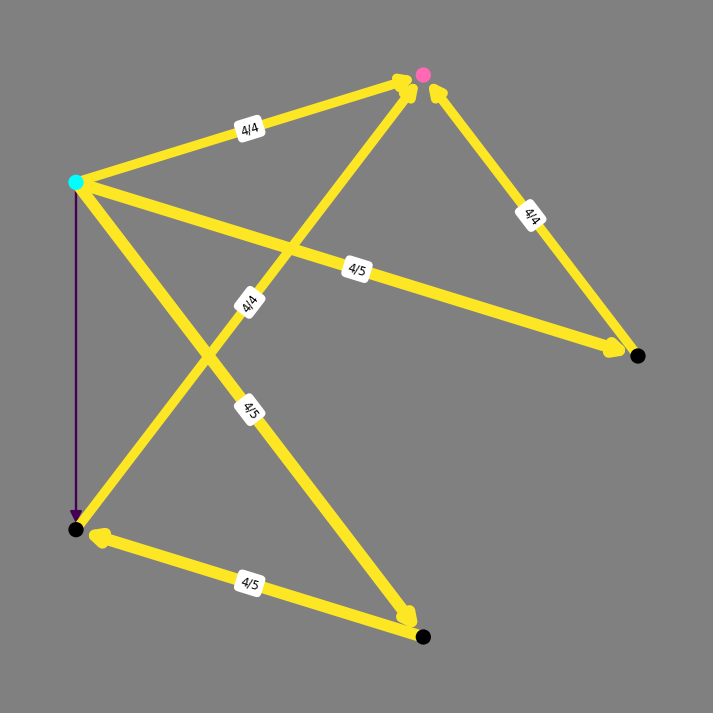

In [183]:
L2 = nx.circular_layout(I)
fig = plt.figure(1, figsize = (4, 4), dpi =  170)
nx.draw(I, pos = L2, width = f, node_size = 30, node_color = Vc, edge_color = c, cmap = plt.cm.Greens)
nx.draw_networkx_edge_labels(I, L2, status, font_size = 5)
fig.set_facecolor('gray')
plt.show()

 Additionally, we could clean out the zero-flow edges. Note that the color scale will adjust since there are no zeroes present any longer.

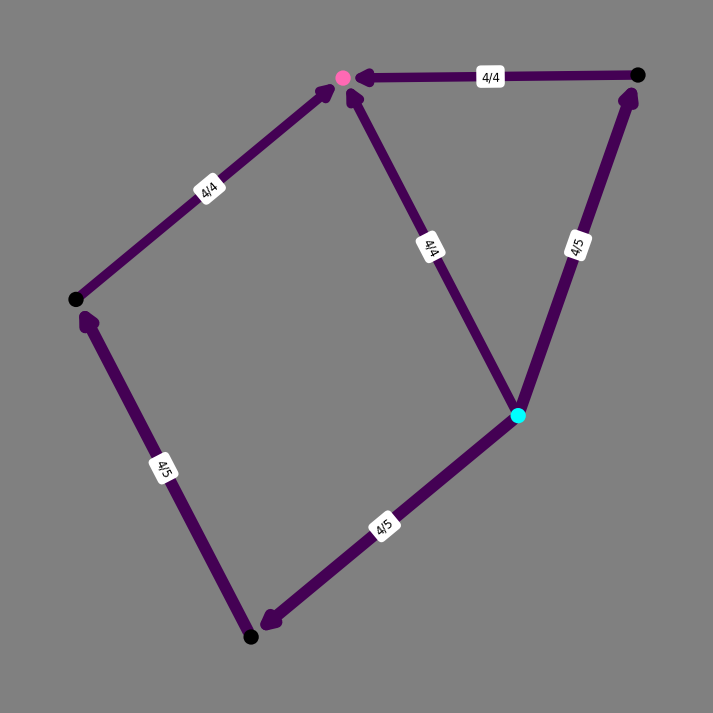

In [184]:
I2 = I.copy()
discard = set()
for u, v in I2.edges():
  if I2[u][v].get('flow', 0) == 0:
    discard.add((u, v))

for u, v in discard:
  I2.remove_edge(u, v)

# update
f2 = [ I[u][v]['capacity'] for u, v in I2.edges ]
c2 = [ I[u][v]['flow'] for u, v in I2.edges ] # they all have a flow now

L3 = nx.kamada_kawai_layout(I2)
fig = plt.figure(1, figsize = (4, 4), dpi =  170)
nx.draw(I2, pos = L3, width = f2, node_size = 30, node_color = Vc, edge_color = c2, cmap = plt.cm.Greens)
nx.draw_networkx_edge_labels(I2, L3, status, font_size = 5)
fig.set_facecolor('gray')
plt.show()